# Loan Amount Project

The main objective of this project is to predict the **loan amount** that a user can be approved for, based on various predictive features such as their **income**, **credit score**, **employment status**, **debt-to-income ratio** and **other features**. By accurately forecasting the loan amount, this project aims to assist financial institutions in making informed lending decisions and to help users understand their loan eligibility.


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import missingno as msno
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import os
from sklearn.metrics import mean_squared_error
from yellowbrick.model_selection import FeatureImportances
from pathlib import Path
import joblib
from scipy import stats
import shap

In [2]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [3]:
train_data.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [4]:
train_data.shape

(30000, 24)

In [5]:
test_data.shape

(20000, 23)

In [6]:
train_data.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [7]:
test_data.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

The test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and validate dataset which will allow us to evaluate the perfomance of the predictive model

In [8]:
complete_data = train_data

In [9]:
complete_data.shape

(30000, 24)

In [10]:
def data_split(df, test_size=0.2, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
loan_amt_train, loan_amt_test = data_split(complete_data, 0.2)

In [12]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train.copy(), loan_amt_test.copy()

In [13]:
loan_amt_train_copy.shape

(24000, 24)

In [14]:
loan_amt_test_copy.shape

(6000, 24)

In [15]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

In [16]:
loan_amt_train_copy.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,24000.000000,20352.000000,24000.000000,23872.000000,21983.000000,22623.000000,24000.000000,24000.000000,20149.000000,24000.000000,24000.000000,2.400000e+04,23725.000000
mean,40.058417,2567.533530,89075.615086,401.409325,2.250512,739.726632,0.193875,502.302000,2567.841029,2.463708,-4.686333,1.320183e+05,47680.600489
std,16.029209,1775.075442,59637.687461,241.893479,0.947379,72.271823,0.395340,288.707474,1776.812939,1.121005,74.227397,9.356624e+04,48224.124688
min,18.000000,378.760000,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,378.760000,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1652.707500,41272.637500,248.932500,2.000000,681.225000,0.000000,251.000000,1653.040000,1.000000,1.000000,6.079394e+04,0.000000
50%,40.000000,2229.965000,75326.655000,375.275000,2.000000,739.880000,0.000000,503.000000,2231.100000,2.000000,1.000000,1.101687e+05,35273.020000
75%,55.000000,3092.775000,120378.247500,521.215000,3.000000,799.090000,0.000000,753.000000,3094.050000,3.000000,1.000000,1.790840e+05,74217.940000
max,65.000000,122966.280000,621497.820000,3419.660000,10.000000,896.260000,1.000000,999.000000,122966.280000,4.000000,1.000000,1.077967e+06,395368.740000


Checking for Missing Values

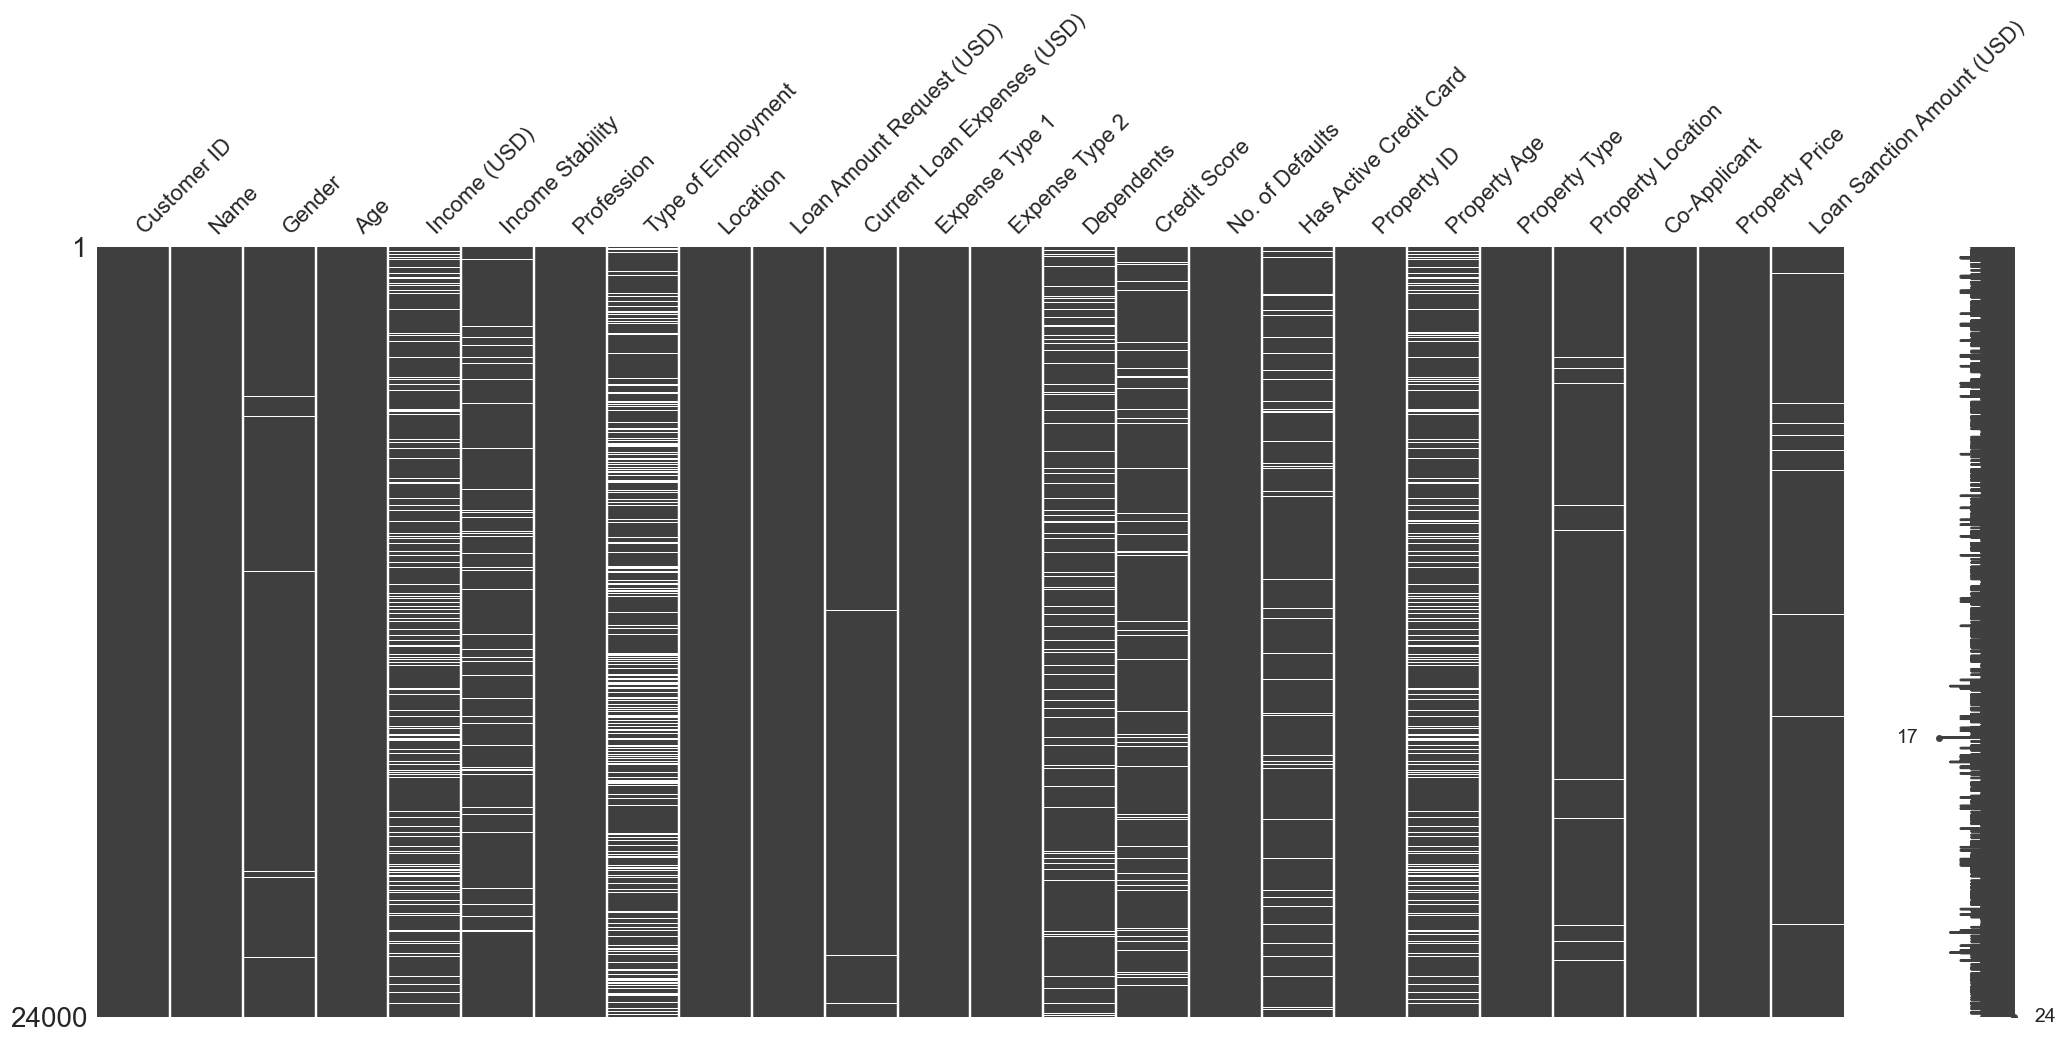

In [17]:
msno.matrix(loan_amt_train_copy)
plt.show()

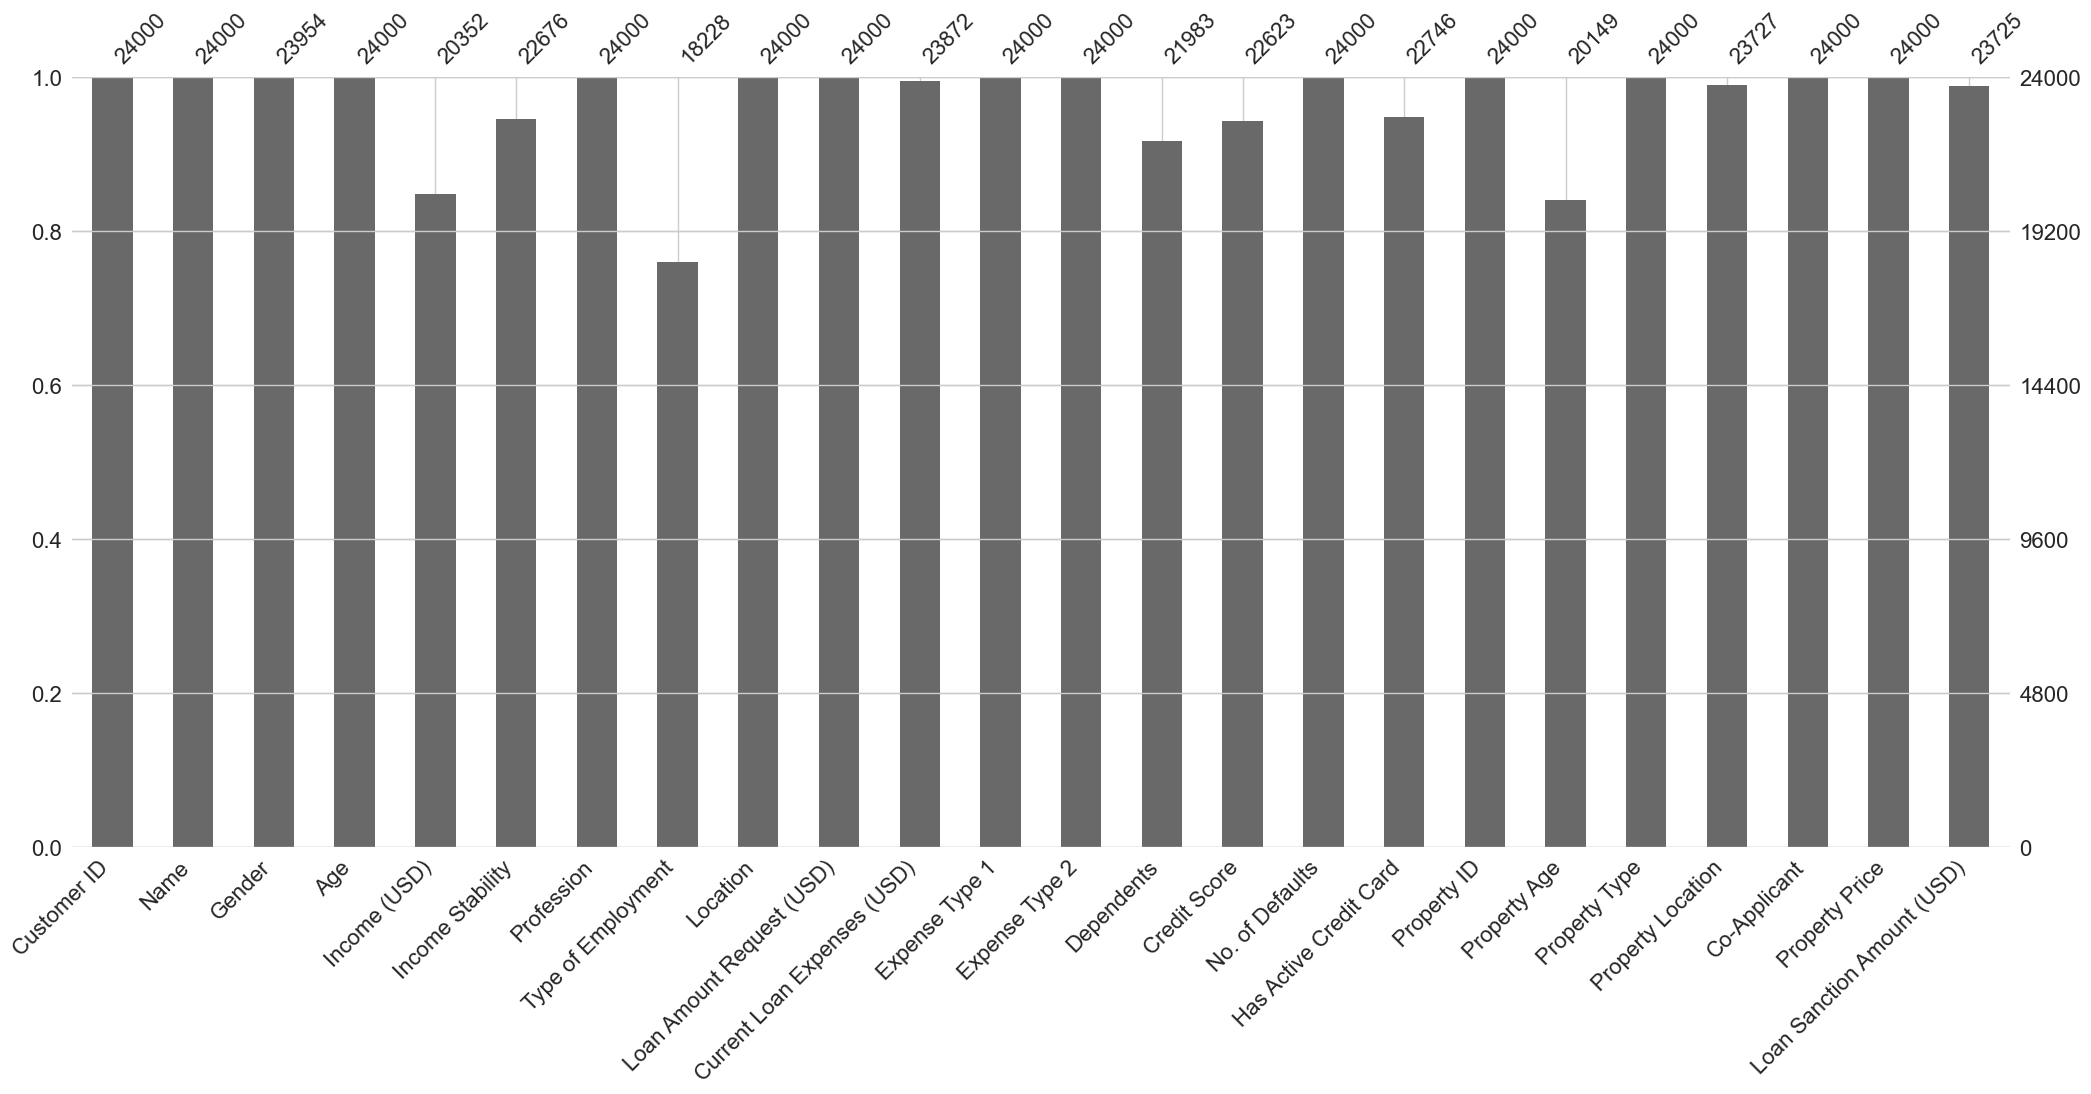

In [18]:
msno.bar(loan_amt_train_copy)
plt.show()

In [19]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value count
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [20]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)' | 'Loan Amount Request (USD)' | 'Current Loan Expenses (USD)' | 'Credit Score' | 'Property Price' | 'Loan Sanction Amount (USD)':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case 'Property Age':
            print('Description:\n{}'.format(df[feature].describe()/365.25))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [21]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(18, 10))
            sns.histplot(df[feature]/365.25, bins=the_bins, kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [22]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
M       12087      50.459213
F       11867      49.540787


In [23]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    match feature:
        case 'Profession' | 'Type of Employment' | 'Dependents':
            fig, ax = plt.subplots(figsize=(8,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0], color='dimgray')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

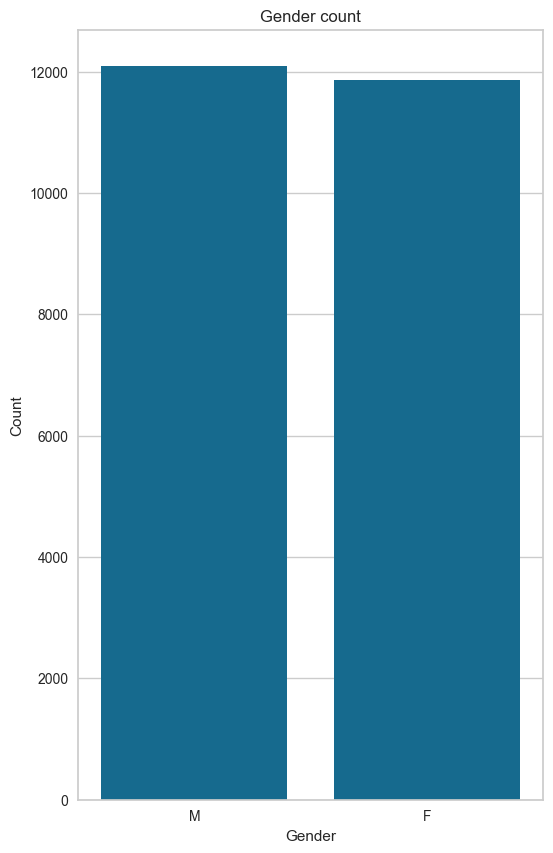

In [24]:
create_bar_plot(loan_amt_train_copy,'Gender')

In [25]:
gen_info_feat(loan_amt_train_copy, 'Age')


Description:
count    24000.000000
mean        40.058417
std         16.029209
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Skewness:
0.05019079901588933


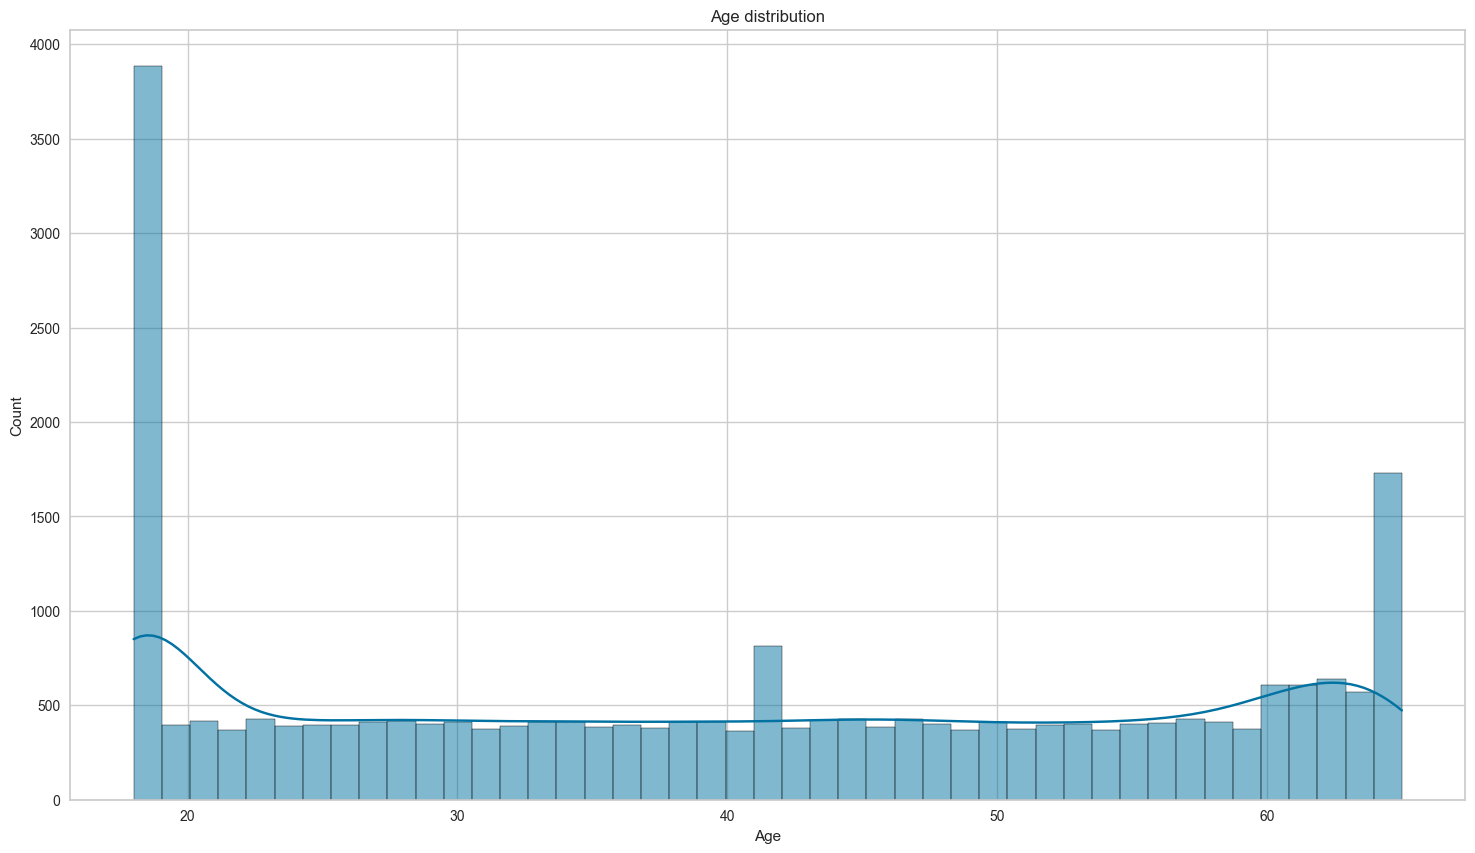

In [26]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

## Age Analysis

- **Age is not normally distributed**.
- We have a large number of applicants who are **18 and 65 years old**.
- The **mean age is 40 years old**.


In [27]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count     20352.000000
mean       2567.533530
std        1775.075442
min         378.760000
25%        1652.707500
50%        2229.965000
75%        3092.775000
max      122966.280000
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
19.759160741711046


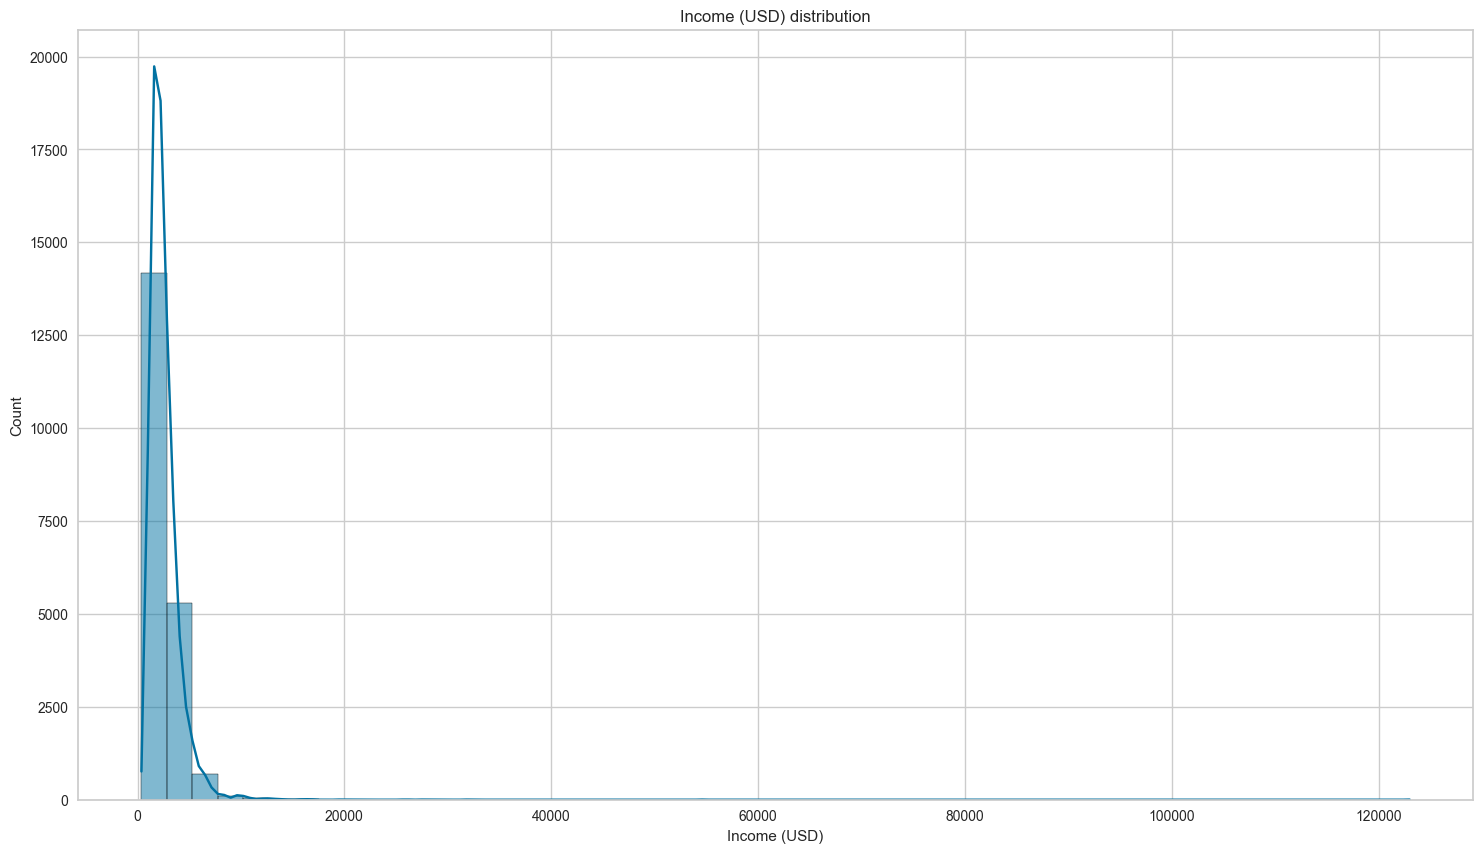

In [28]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [29]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
Income Stability                      
Low               20617      90.919915
High               2059       9.080085


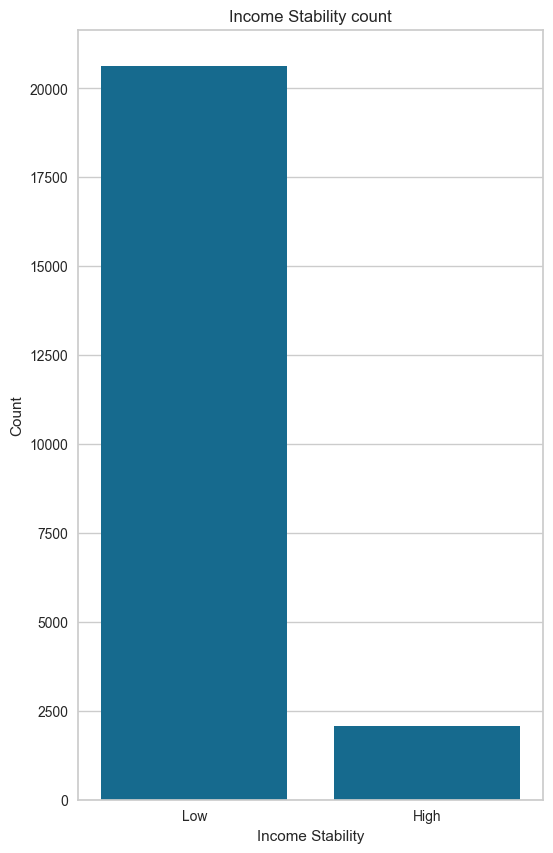

In [30]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

In [31]:
gen_info_feat(loan_amt_train_copy,'Profession')

Description:
count       24000
unique          7
top       Working
freq        13509
Name: Profession, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Profession                                
Working               13509      56.287500
Commercial associate   6433      26.804167
Pensioner              2193       9.137500
State servant          1861       7.754167
Unemployed                2       0.008333
Businessman               1       0.004167
Student                   1       0.004167


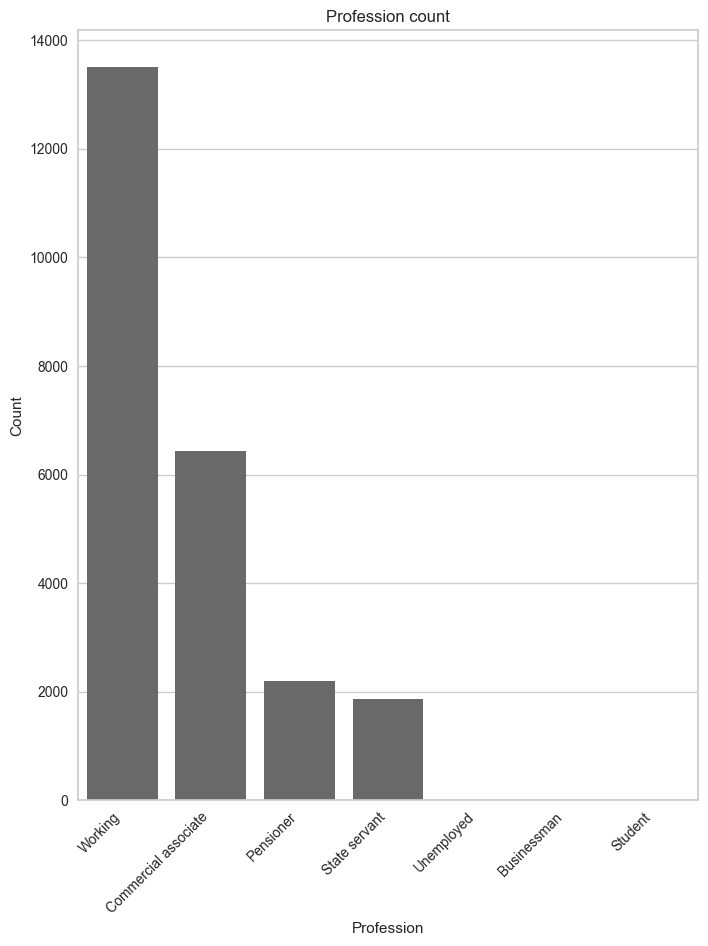

In [32]:
create_bar_plot(loan_amt_train_copy, 'Profession')

In [33]:
gen_info_feat(loan_amt_train_copy,'Type of Employment')

Description:
count        18228
unique          18
top       Laborers
freq          4495
Name: Type of Employment, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Type of Employment                         
Laborers                4495      24.659864
Sales staff             2997      16.441738
Core staff              2605      14.291200
Managers                1996      10.950187
Drivers                 1273       6.983761
Accountants             1096       6.012728
High skill tech staff   1044       5.727452
Medicine staff           669       3.670178
Security staff           477       2.616853
Cooking staff            446       2.446785
Cleaning staff           283       1.552557
Private service staff    280       1.536098
Secretaries              132       0.724161
Low-skill Laborers       125       0.685758
Waiters/barmen staff     122    

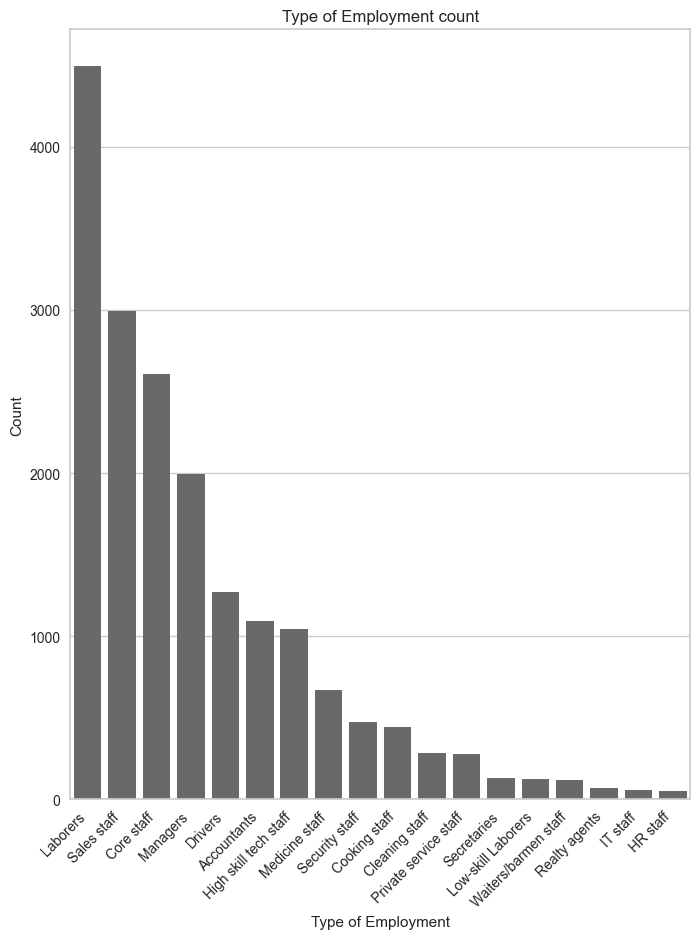

In [34]:
create_bar_plot(loan_amt_train_copy,'Type of Employment')

In [35]:
gen_info_feat(loan_amt_train_copy,'Location')

Description:
count          24000
unique             3
top       Semi-Urban
freq           17157
Name: Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Location                        
Semi-Urban  17157        71.4875
Rural        4320        18.0000
Urban        2523        10.5125


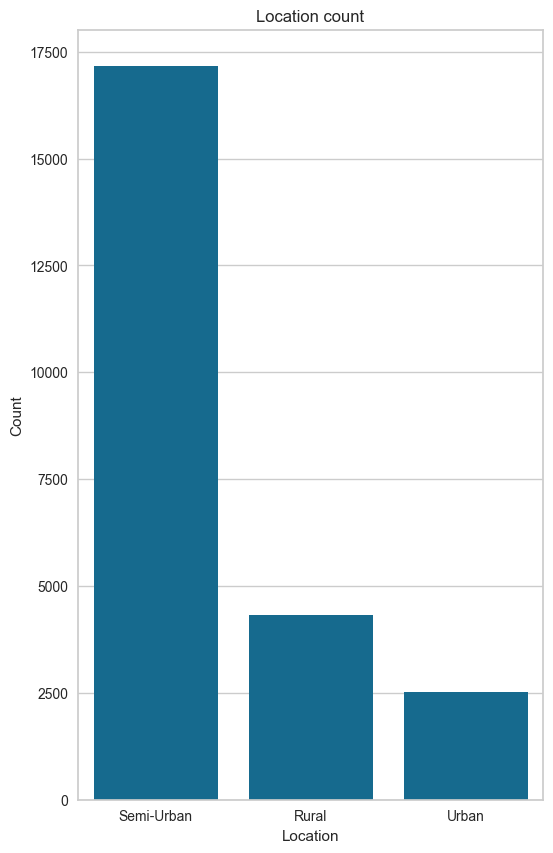

In [36]:
create_bar_plot(loan_amt_train_copy,'Location')

In [37]:
gen_info_feat(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count     24000.000000
mean      89075.615086
std       59637.687461
min        6048.240000
25%       41272.637500
50%       75326.655000
75%      120378.247500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2491353741072624


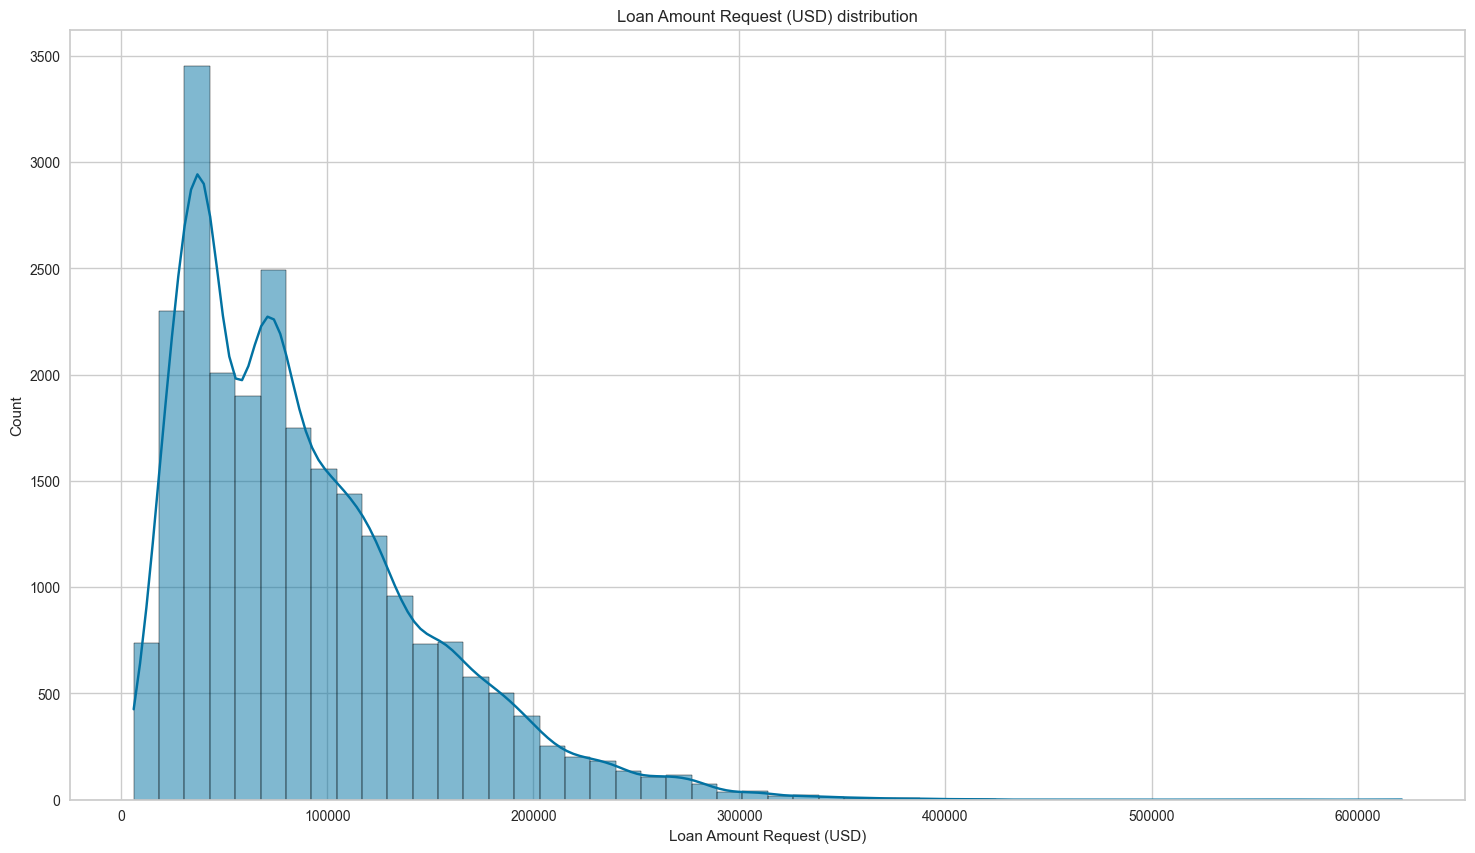

In [38]:
create_hist_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

In [39]:
gen_info_feat(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count    23872.000000
mean       401.409325
std        241.893479
min       -999.000000
25%        248.932500
50%        375.275000
75%        521.215000
max       3419.660000
Name: Current Loan Expenses (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.032881699548371904


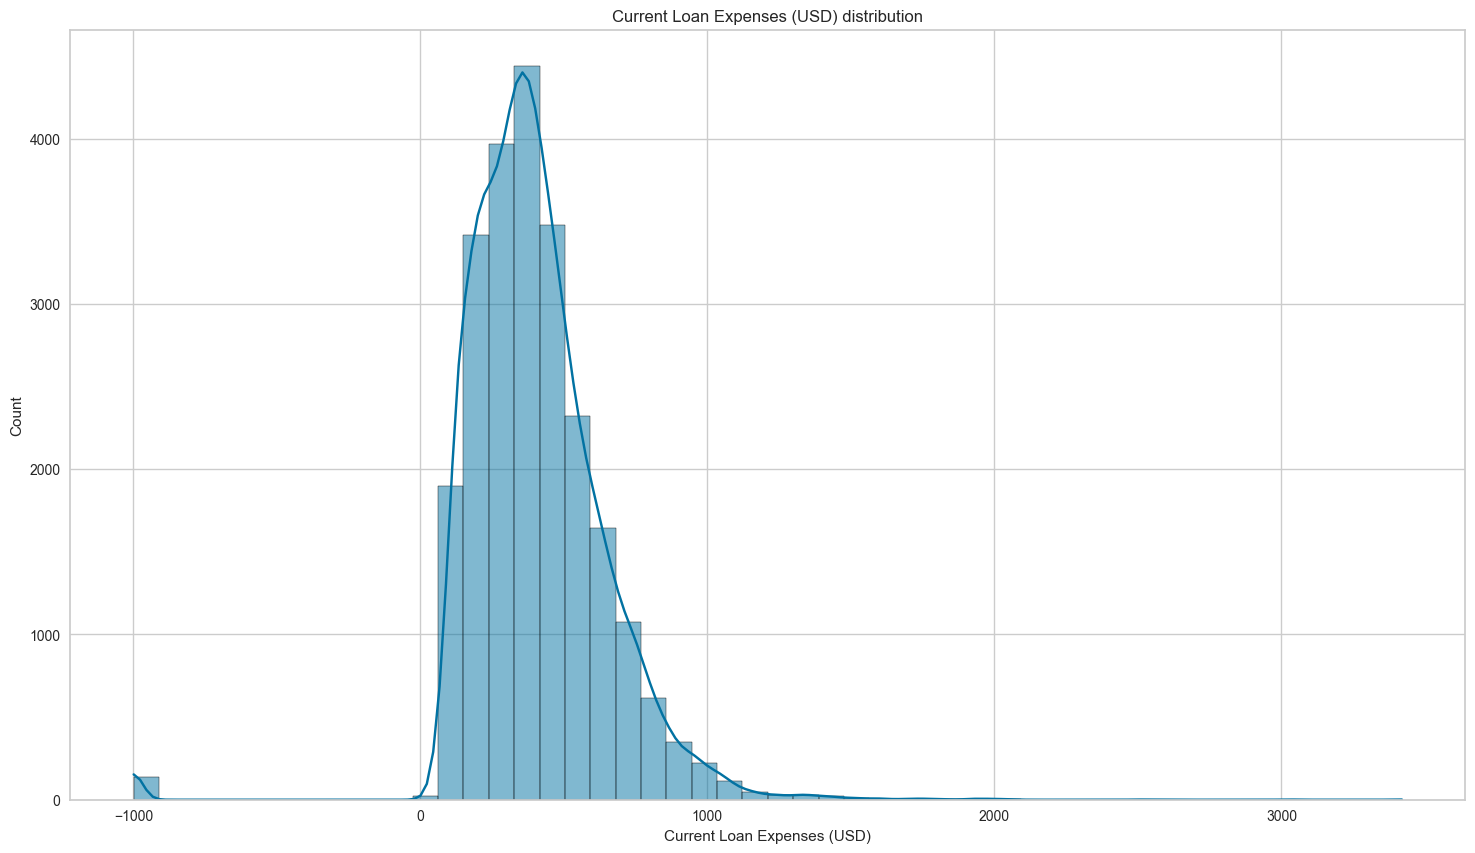

In [40]:
create_hist_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

In [41]:
gen_info_feat(loan_amt_train_copy,'Expense Type 1')

Description:
count     24000
unique        2
top           N
freq      15361
Name: Expense Type 1, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Expense Type 1                      
N               15361      64.004167
Y                8639      35.995833


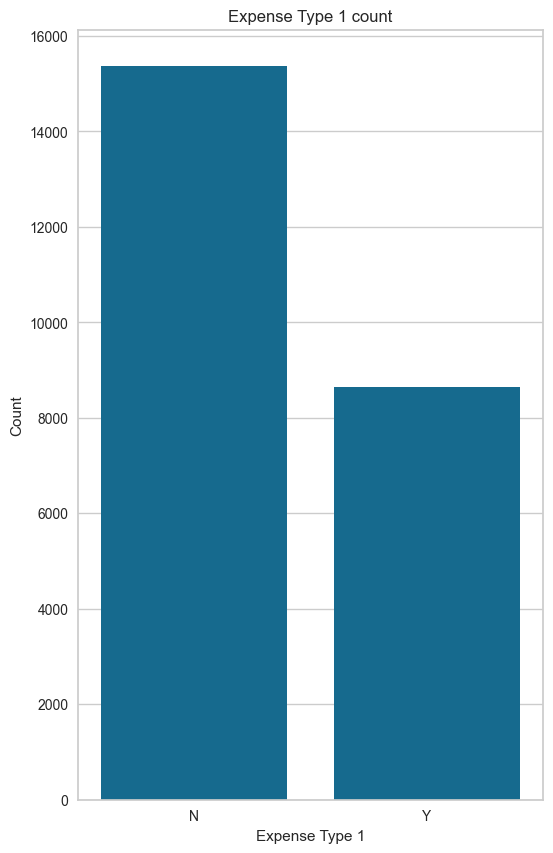

In [42]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

In [43]:
gen_info_feat(loan_amt_train_copy,'Expense Type 2')

Description:
count     24000
unique        2
top           Y
freq      16116
Name: Expense Type 2, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Expense Type 2                      
Y               16116          67.15
N                7884          32.85


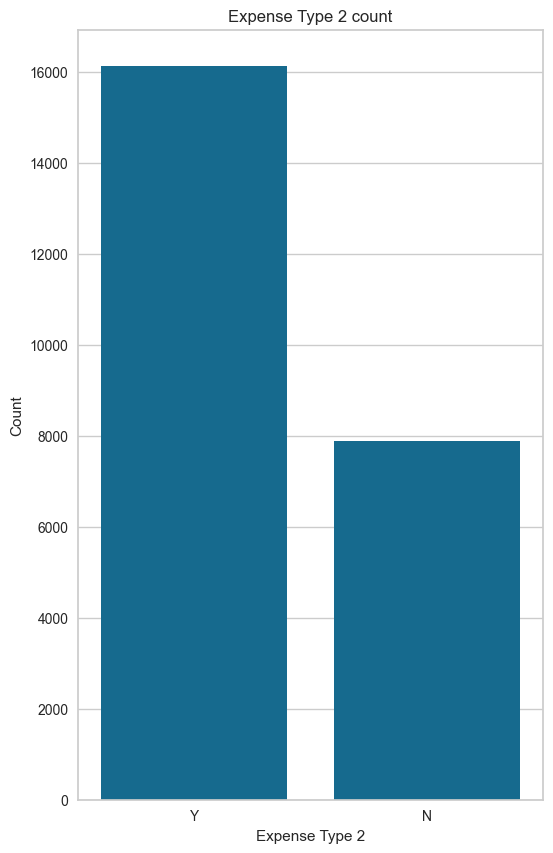

In [44]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

In [45]:
gen_info_feat(loan_amt_train_copy,'Dependents')

Description:
count    21983.000000
mean         2.250512
std          0.947379
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Dependents, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
            Count  Frequency (%)
Dependents                      
2.0         10471      47.632261
3.0          4568      20.779693
1.0          4447      20.229268
4.0          2160       9.825774
5.0           293       1.332848
6.0            37       0.168312
7.0             5       0.022745
8.0             1       0.004549
10.0            1       0.004549


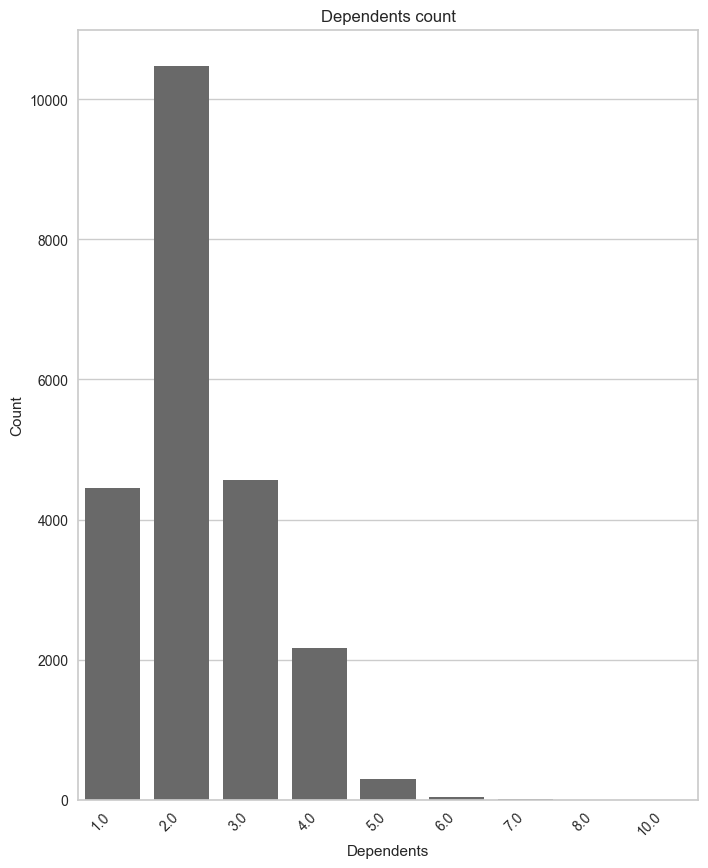

In [46]:
create_bar_plot(loan_amt_train_copy,'Dependents')

In [47]:
gen_info_feat(loan_amt_train_copy,'Credit Score')

Description:
count    22623.000000
mean       739.726632
std         72.271823
min        580.000000
25%        681.225000
50%        739.880000
75%        799.090000
max        896.260000
Name: Credit Score, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.021671118190646724


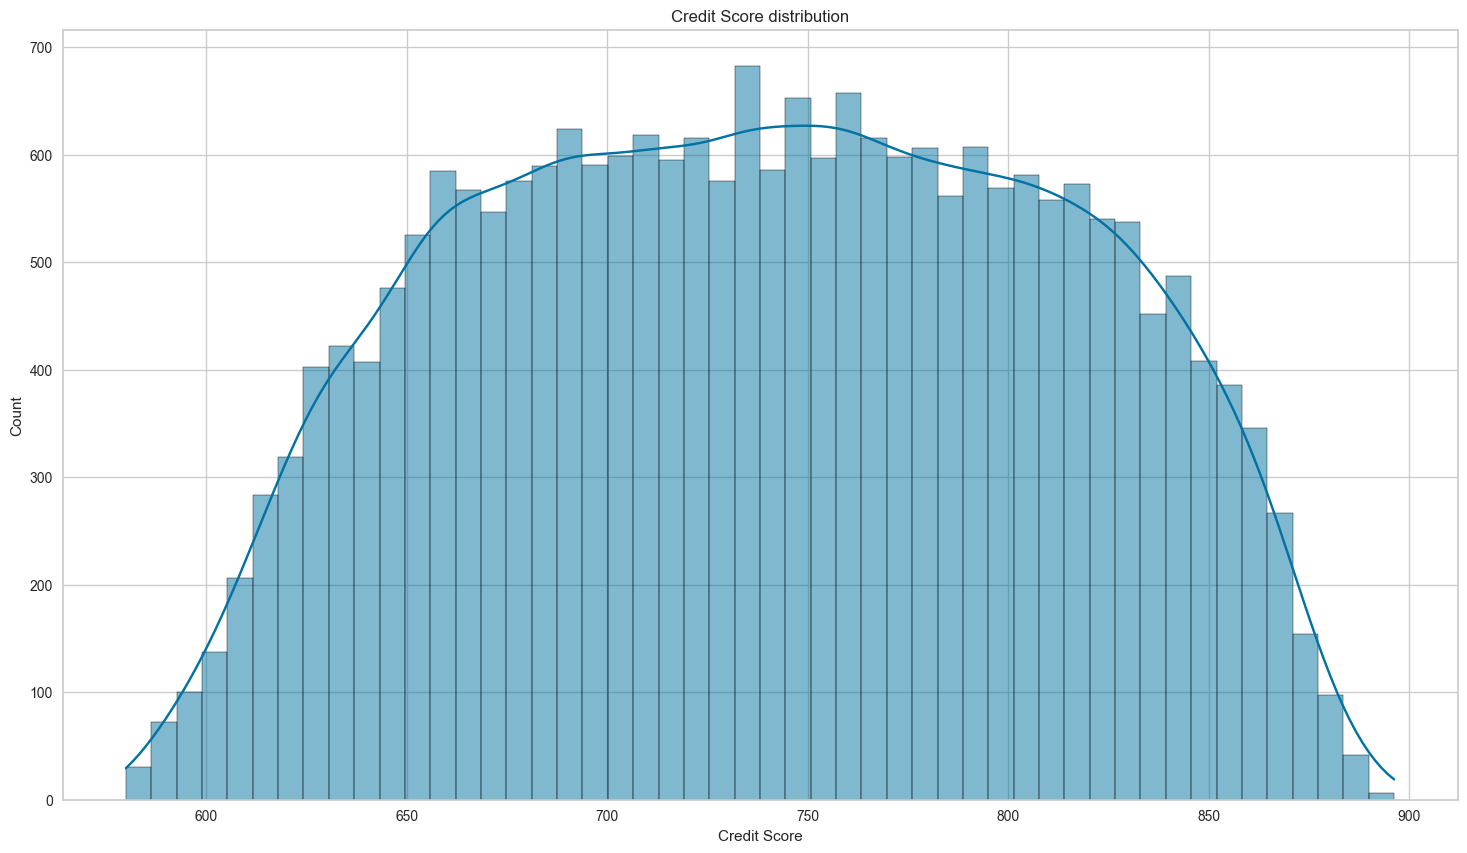

In [48]:
create_hist_plot(loan_amt_train_copy, 'Credit Score')

KeyboardInterrupt: 

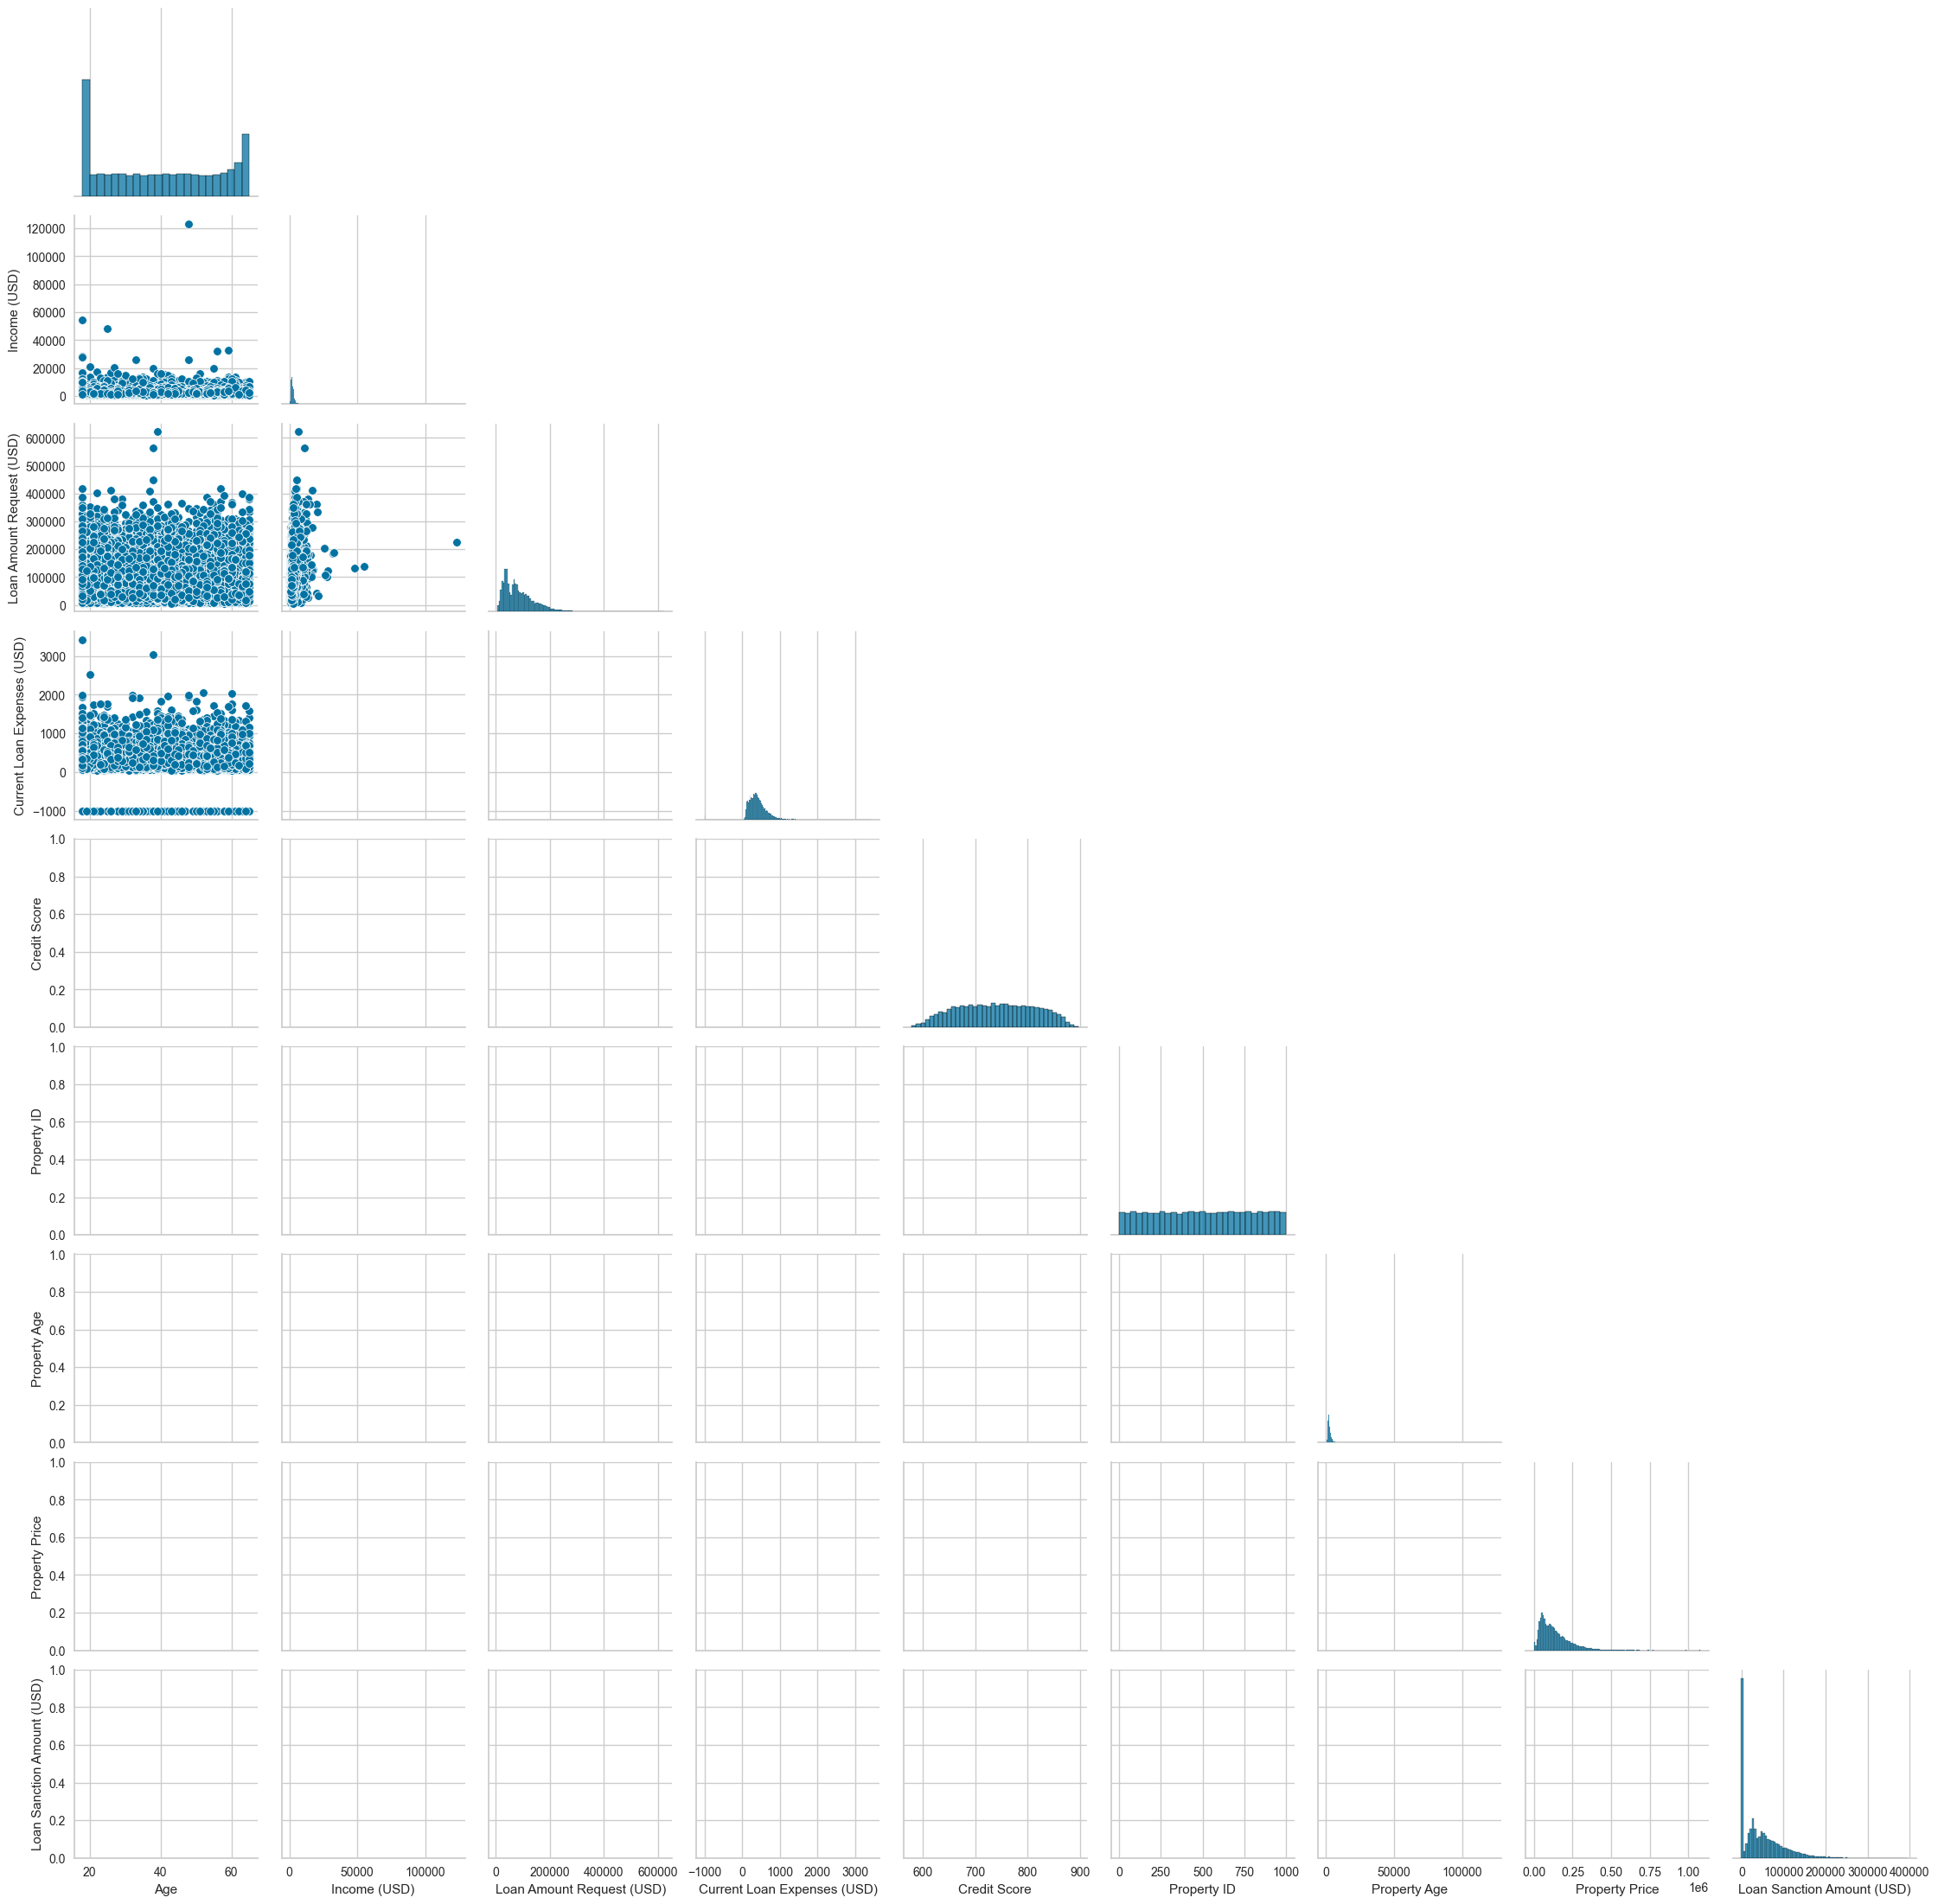

In [49]:
sns.pairplot(loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1),corner=True)
plt.show()

- There is a positive correlation between the loan amount request and the current loan expenses.
- There is also a perfect positive correlation between the income and the property age.
- There is a colleration between property price and loan amount request.
- There is a colleration between loan sanction amount and loan amount request.
- We also find a correlation between the property price and current loan expenses.
- There is a correlation between loan sanction amount and current loan expenses.
- There is a correlation between property price and loan sanction amount.

In [51]:
loan_amt_train_copy[['Loan Amount Request (USD)','Loan Sanction Amount (USD)']]

,Loan Amount Request (USD),Loan Sanction Amount (USD)
0,294604.89,235683.91
1,132263.08,0.00
2,112307.54,72999.90
3,24268.35,0.00
4,76342.04,57256.53
...,...,...
23995,122864.44,86005.11
23996,101151.00,65748.15
23997,91833.60,64283.52
23998,62065.25,43445.68


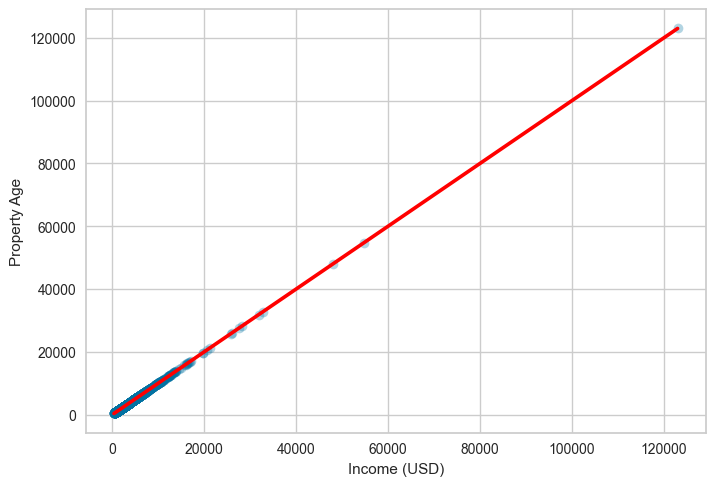

In [52]:
sns.regplot(x='Income (USD)',y='Property Age',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

- We have a perfect correlation between the income and the property age. The more the income, the older the property.

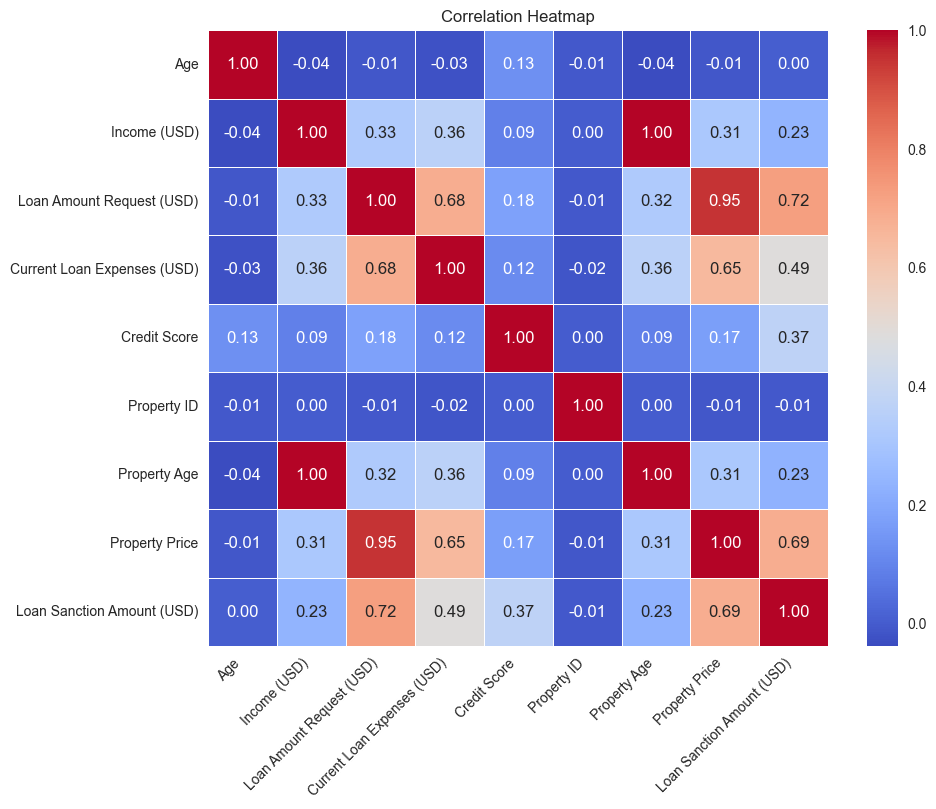

In [53]:
features = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
            'Credit Score', 'Property ID', 'Property Age', 'Property Price', 'Loan Sanction Amount (USD)']

# Extract the selected columns
df_selected = loan_amt_train_copy[features]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

- There are several moderate to strong positive correlations between Loan Amount Request, Property Price, Current Loan Expenses, and Loan Sanction Amount. This indicates that these variables tend to increase or decrease together.
- Age has weak correlations with other variables, suggesting that it may not be strongly predictive of other financial indicators.
- Income shows moderate positive correlations with Loan Amount Request, Property Price, and Current Loan Expenses, indicating that higher income individuals tend to request larger loans and have more expensive properties.
- Credit Score has weak positive correlations with other financial indicators, suggesting a potential but not strong influence on loan-related decisions.

C:\Users\USER\AppData\Local\Temp\ipykernel_6360\2384598774.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x=cat_features[cat_ft_count], y='Loan Sanction Amount (USD)', data=loan_amt_train_copy, palette=palette)
C:\Users\USER\AppData\Local\Temp\ipykernel_6360\2384598774.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
C:\Users\USER\AppData\Local\Temp\ipykernel_6360\2384598774.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x=cat_features[cat_ft_count], y='Loan Sanction Amount (USD)', data=loan_amt_train_copy, palette=palette)
C:\Users\USER\AppDa

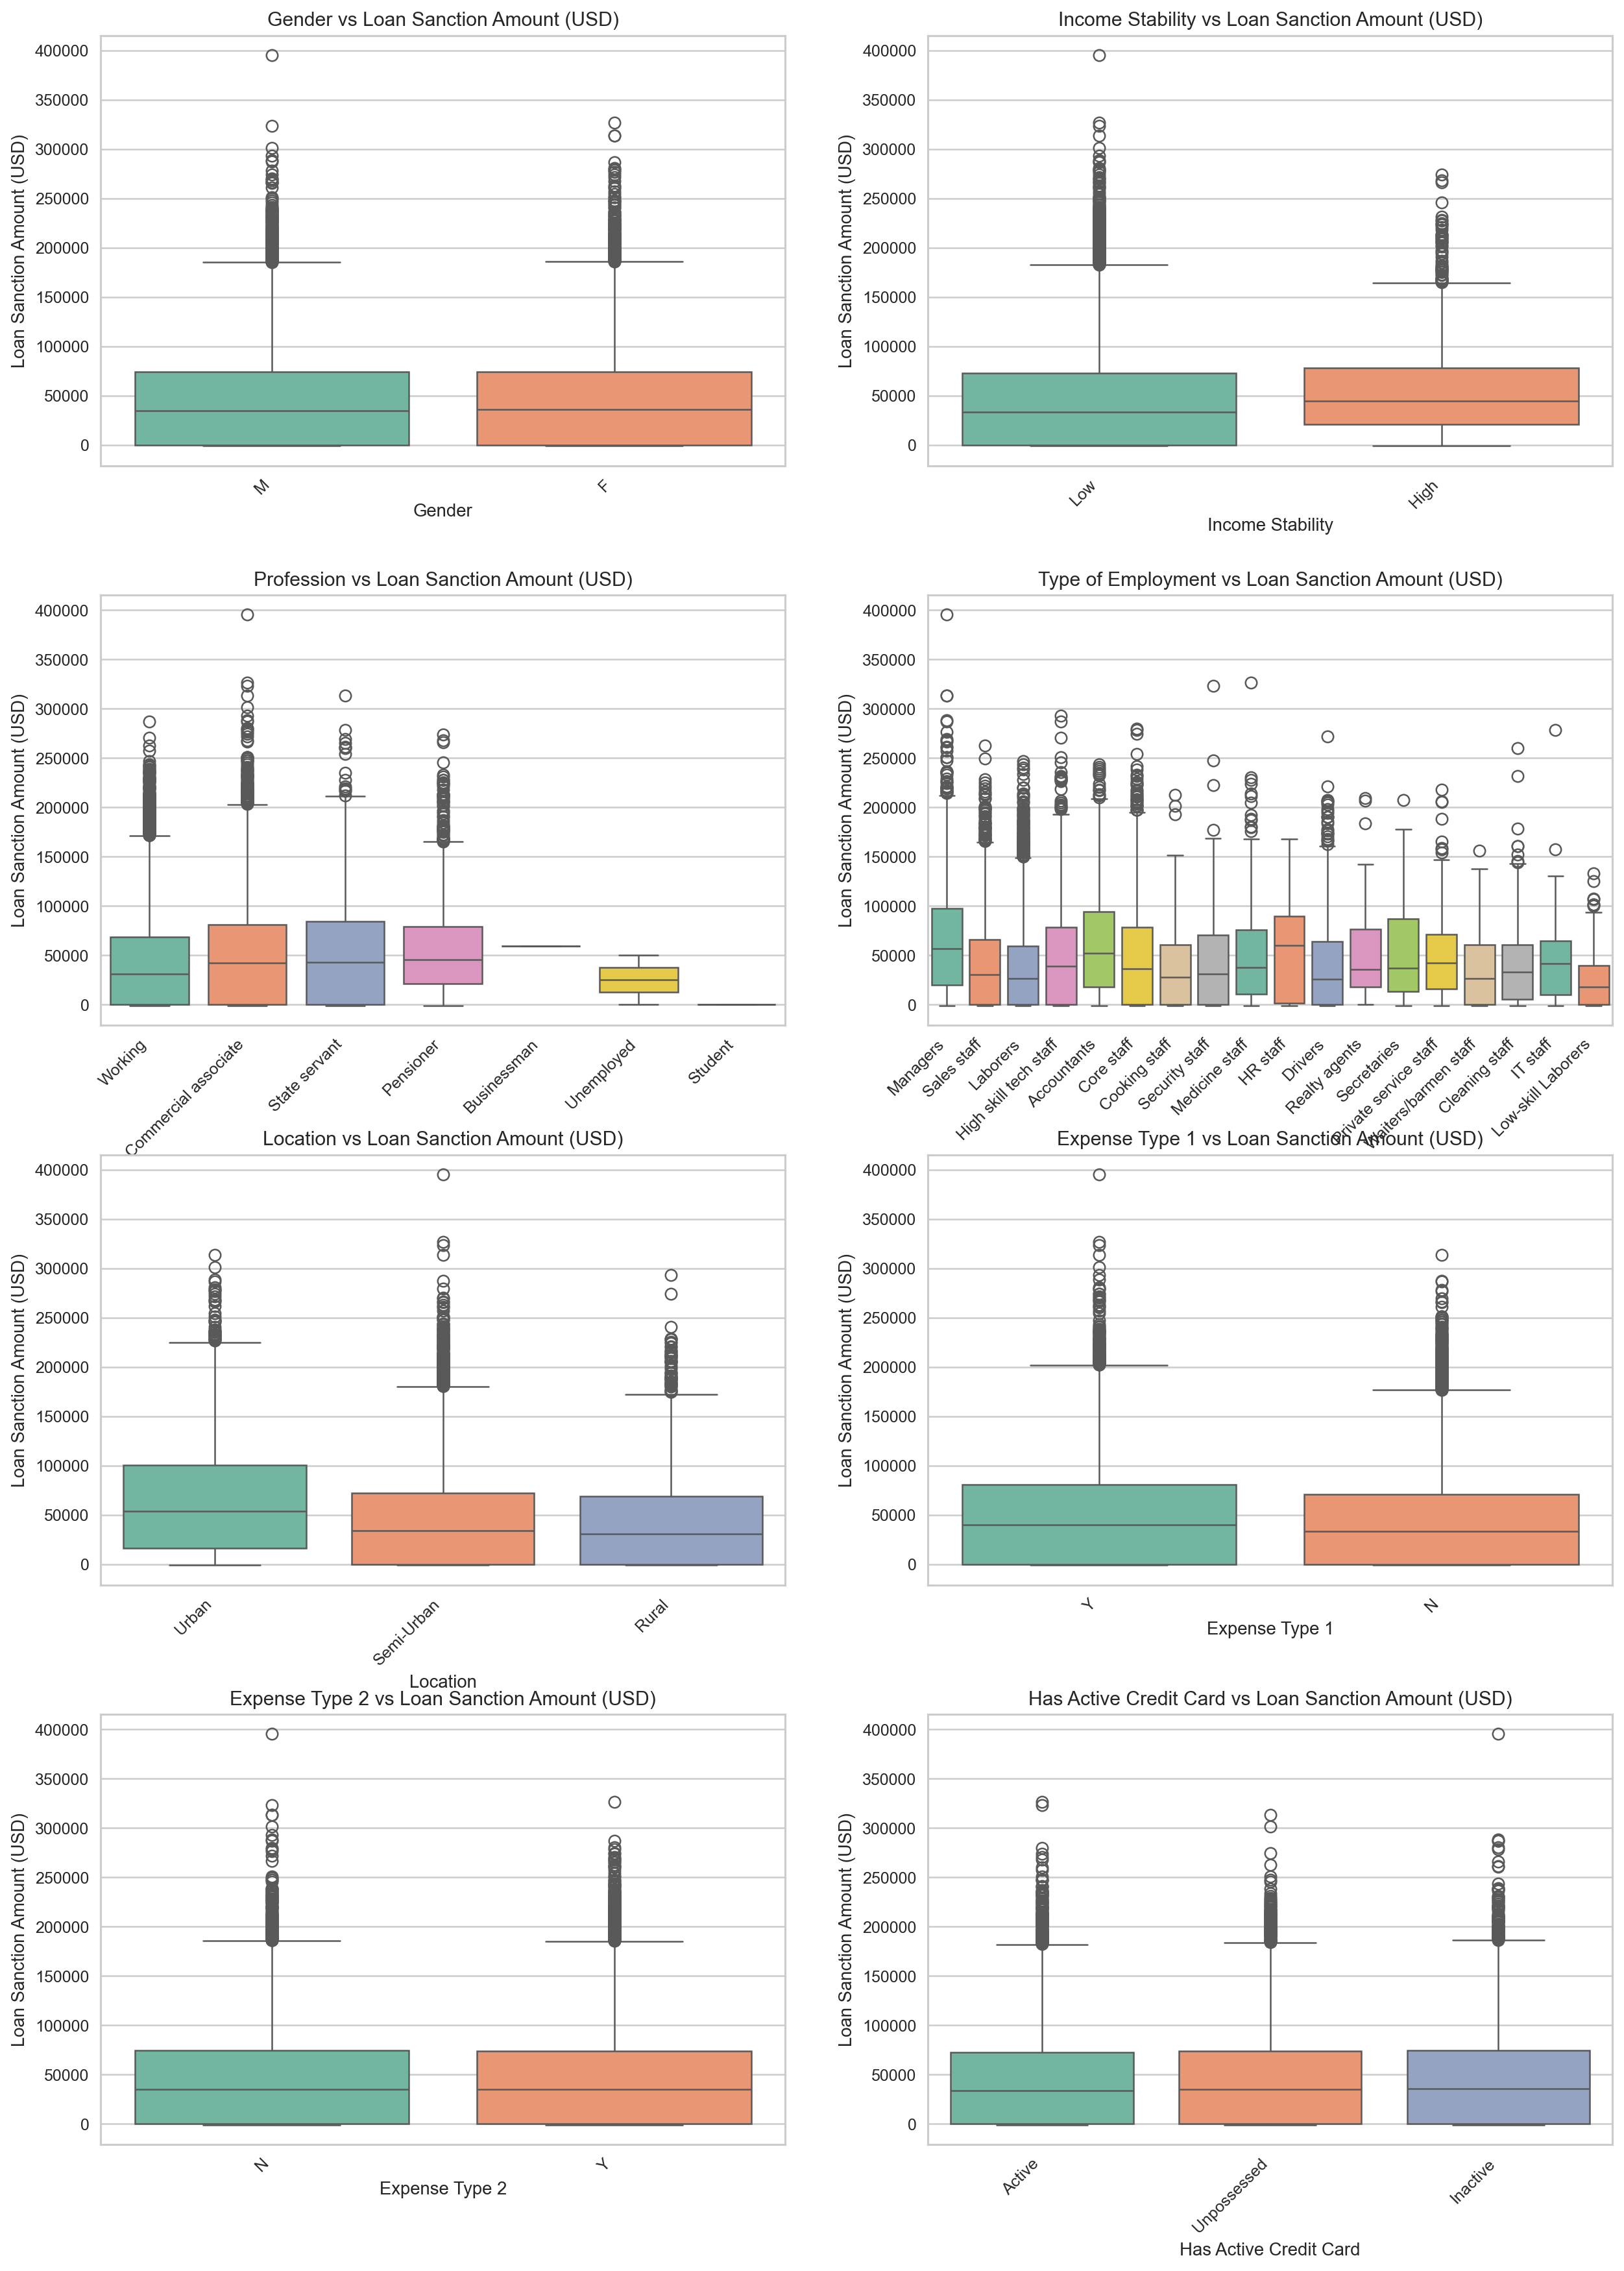

In [54]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=5.0)

cat_features = ['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location']
palette = 'Set2'  

for cat_ft_count, ax in enumerate(axes.flat):  # Flatten axes for easier iteration
    sns.boxplot(ax=ax, x=cat_features[cat_ft_count], y='Loan Sanction Amount (USD)', data=loan_amt_train_copy, palette=palette)
    ax.set_title(cat_features[cat_ft_count] + " vs Loan Sanction Amount (USD)")
    ax.set_ylabel('Loan Sanction Amount (USD)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

plt.show()


- People with high income stability were given a high loan sanction amount
- Managers, HR staff and accounts received a median loan sanction amount of $5000
- People who live in urban area received the highest loan sanction amount

Outliers imputer

In [55]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Property Age', 'Property Price']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

Missing values imputer

In [56]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft = ['Gender','Income Stability','Dependents','Has Active Credit Card','Property Location'], median_imputed_ft = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # drop missing values in the target feature
            df.dropna(inplace=True, axis=0, subset=['Loan Sanction Amount (USD)'])
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

less frequent professions

In [57]:
class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            # only keep the professions that are not in the profession_list
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe")
            return df

Drop Columns

In [58]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Customer ID','Name','Type of Employment','Property ID']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [59]:
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_999_val=['Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)', 'Property Price']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for ft in self.feat_with_999_val:
                # replace any occurance of -999.000 with 0
                df[ft].replace(-999.000,0,inplace=True,regex=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [60]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Property Age']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found')
            return df

In [61]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [62]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Income Stability']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

In [63]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
        ('drop uncommon profession', DropUncommonProfession()),
        ('missing value imputer', MissingValueImputer()),
        ('drop features', DropFeatures()),
        ('-999 value imputer', ValueImputer()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', MinMaxWithFeatNames()),
        ('one hot encoder', OneHotWithFeatNames())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [64]:
pd.options.mode.chained_assignment = None
loan_amt_train_copy_prep = full_pipeline(loan_amt_train_copy)

In [65]:
loan_amt_train_copy_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,...,Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.746567,0.721287,1.0,0.208847,1,0.553696,3,1,0.702162,0.00
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.684906,0.751840,1.0,0.399734,0,0.553696,2,1,0.442871,72999.90
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.244800,0.350610,2.0,0.190445,0,0.553696,2,1,0.085481,0.00
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.552035,0.853488,2.0,0.808038,0,0.569371,3,1,0.398989,57256.53
5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.624558,0.934320,2.0,0.572946,0,0.693611,2,1,0.408239,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.543599,0.794840,3.0,0.065642,1,0.522780,2,1,0.386377,0.00
23995,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.718361,0.590024,1.0,0.676374,1,0.553696,2,1,0.551492,86005.11
23997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.613499,0.563531,2.0,0.676658,0,0.412367,4,1,0.307640,64283.52
23998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.487509,0.637858,3.0,0.461867,0,0.553696,4,1,0.201033,43445.68


In [66]:
X_loan_amt_train_prep, y_loan_amt_train_prep = loan_amt_train_copy_prep.loc[:, loan_amt_train_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_train_copy_prep['Loan Sanction Amount (USD)']

In [67]:
X_loan_amt_train_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,...,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.553592,0.746567,0.721287,1.0,0.208847,1,0.553696,3,1,0.702162
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.553592,0.684906,0.751840,1.0,0.399734,0,0.553696,2,1,0.442871
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.553592,0.244800,0.350610,2.0,0.190445,0,0.553696,2,1,0.085481
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.569371,0.552035,0.853488,2.0,0.808038,0,0.569371,3,1,0.398989
5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.693611,0.624558,0.934320,2.0,0.572946,0,0.693611,2,1,0.408239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.522780,0.543599,0.794840,3.0,0.065642,1,0.522780,2,1,0.386377
23995,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.553592,0.718361,0.590024,1.0,0.676374,1,0.553696,2,1,0.551492
23997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.412367,0.613499,0.563531,2.0,0.676658,0,0.412367,4,1,0.307640
23998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.553592,0.487509,0.637858,3.0,0.461867,0,0.553696,4,1,0.201033


In [68]:
y_loan_amt_train_prep

1            0.00
2        72999.90
3            0.00
4        57256.53
5            0.00
           ...   
23994        0.00
23995    86005.11
23997    64283.52
23998    43445.68
23999    55597.38
Name: Loan Sanction Amount (USD), Length: 21477, dtype: float64

In [69]:
Regressors = {
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=20),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=20),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=20),
    'SVM Regression': SVR(),
}

In [70]:
def fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    rmse_scores_path = Path('saved_models/{0}/rmse_{0}'.format(model_name))
    try:
        #check if the file exists
        rmse_scores_path.resolve(strict=True)
    except FileNotFoundError:
        scores = cross_val_score(model, X_loan_amt_train_prep, y_loan_amt_train_prep, cv=3, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))
        joblib.dump(rmse_scores, 'saved_models/{0}/rmse_{0}'.format(model_name))
    else:
        rmse_scores = joblib.load('saved_models/{0}/rmse_{0}'.format(model_name))
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))

In [71]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}/'.format(model_name)):
        os.makedirs('saved_models/{}/'.format(model_name))

In [72]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)





----------------------  Random Forest Regression  ----------------------


Score: [21286.61586596 21193.96319948 20393.81354637]
Mean score: 20958.13087060269
Standard deviation: 400.82137416036636




----------------------  Linear Regression  ----------------------


Score: [26528.00223007 26865.05663364 25603.23032186]
Mean score: 26332.096395191013
Standard deviation: 533.4389889357192




----------------------  Lasso Regression  ----------------------


Score: [26523.91704521 26851.2967308  25577.31212505]
Mean score: 26317.508633684618
Standard deviation: 540.1928780128102




----------------------  Decision Tree Regression  ----------------------


Score: [29492.75103329 29012.27620391 29237.80386091]
Mean score: 29247.6103660352
Standard deviation: 196.27555642420364




----------------------  Gradient Boosting Regression  ----------------------


Score: [20926.44099271 21016.47171169 20069.83209133]
Mean score: 20670.914931907486
Standard deviation: 426.61600104466703



In [73]:
def feat_importance(model_trn, model_name):
    # change xtick font size
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    # top 10 most predictive features
    top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
    # top 10 least predictive features
    bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
    #change the figure size
    plt.figure(figsize=(10, 4))
    #change x label font size
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    top_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    top_10_feat.show()
    print('\n')
    plt.figure(figsize=(10, 4))
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    bottom_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    bottom_10_feat.show()
    print('\n')

In [74]:
def shap_ft_importance(model_name, model,X_loan_amt_train_prep,y_loan_amt_train_prep):
    # get the model
    model = model
    # fit the model
    model.fit(X_loan_amt_train_prep,y_loan_amt_train_prep)
    # load JS visualization code to notebook
    shap.initjs()
    # get the shap values
    shap_values = shap.TreeExplainer(model).shap_values(X_loan_amt_train_prep)
    # get the feature importance
    shap_ft_importance = shap.summary_plot(shap_values,features=X_loan_amt_train_prep,feature_names=X_loan_amt_train_prep.columns, show=False)
    plt.savefig('saved_final_models/{0}/shap_ft_importance_{0}.png'.format(model_name))

In [75]:
def train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        #train the model with the best parameters
        best_model_trn = best_model.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [76]:
def fine_tune_model(model_name,model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
        rand_search.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    return best_model

In [77]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

In [78]:
parameters = [
    {'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
]

In [79]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [80]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [81]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

21431.71269414058 {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
21438.42088707018 {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
21430.0611871362 {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
nan {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
nan {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
nan {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
nan {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
21290.030886772634

In [82]:
best_rand_for_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


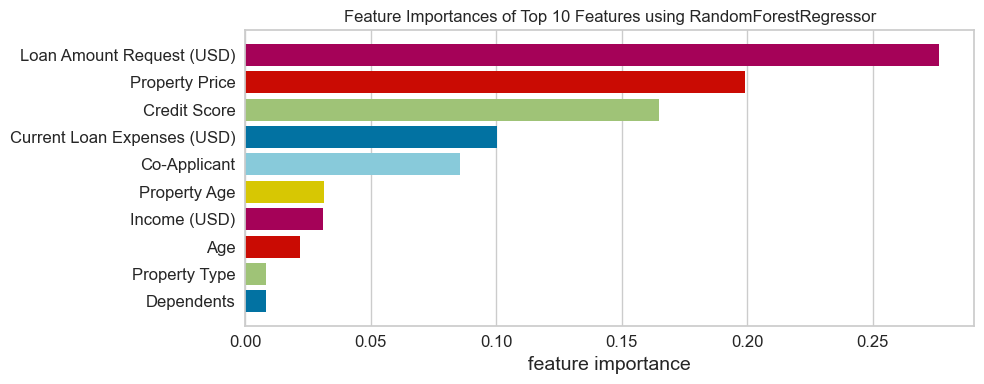

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


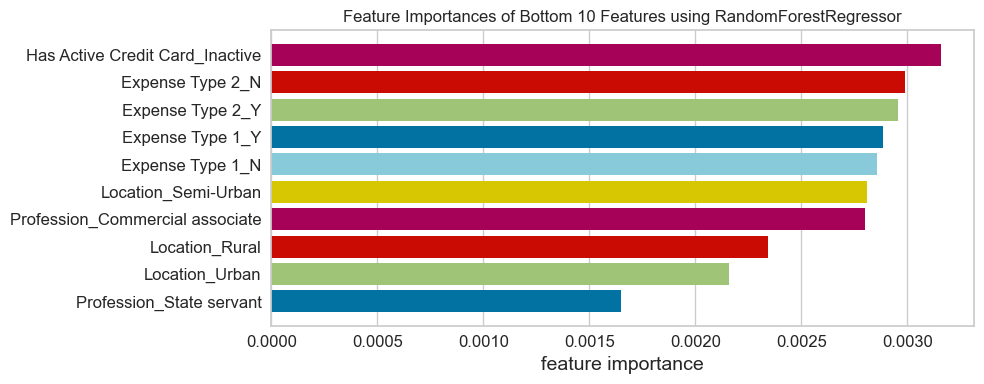

In [83]:
feat_importance(best_rand_for_trn, model_name)

In [84]:
best_rand_for_trn

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=2000, random_state=42)

In [85]:
loan_amt_test_copy.head

<bound method NDFrame.head of      Customer ID              Name Gender  Age  Income (USD) Income Stability  \
0        C-25648    Necole Newbold      M   48       2631.71              Low   
1        C-27924       Ranee Yager      F   58       4445.65              NaN   
2        C-27842      Ivory Toledo      M   25       1586.37              Low   
3         C-7269      Todd Turcios      F   18           NaN              Low   
4        C-47464   Beatriz Lessman      F   36       1591.72              Low   
...          ...               ...    ...  ...           ...              ...   
5995      C-8024  Felicita Terhaar      F   50       1683.33              Low   
5996     C-34308        Ines Gayer      M   55       2120.96              Low   
5997     C-37035   Cherri Primeaux      M   18       3138.78              Low   
5998     C-22839    Frances Branum      M   30           NaN              NaN   
5999     C-11560   Evelyne Burkley      F   46       2720.74              Low  

In [86]:
loan_amt_test_copy_prep = full_pipeline(loan_amt_test_copy)

In [87]:
loan_amt_test_copy_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,...,Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.503370,0.720693,4.0,0.209585,0,0.650109,3,1,0.205270,0.00
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.603517,0.606290,3.0,0.387274,0,0.910686,1,1,0.302928,62192.62
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.780812,0.686724,2.0,0.298495,1,0.438250,4,1,0.515736,99950.54
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.710375,0.645418,3.0,0.091321,0,0.550816,2,1,0.607603,0.00
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.413700,0.430242,3.0,0.474979,0,0.439545,4,1,0.210934,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.777311,0.711765,4.0,0.774940,0,0.672130,2,1,0.639065,106164.56
5994,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.468389,0.478803,1.0,0.399818,0,0.550816,1,1,0.216936,37951.71
5995,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.126437,0.244992,1.0,0.460579,0,0.461272,4,1,0.068291,9736.10
5997,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.555395,0.595469,2.0,0.729165,0,0.732653,1,1,0.241677,57763.88


In [88]:
X_loan_amt_test_prep, y_loan_amt_test_prep = loan_amt_test_copy_prep.loc[:, loan_amt_test_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_test_copy_prep['Loan Sanction Amount (USD)']

In [89]:
final_predictions = best_rand_for_trn.predict(X_loan_amt_test_prep)

In [90]:
final_predictions = best_rand_for_trn.predict(X_loan_amt_test_prep)

final_mse = mean_squared_error(y_loan_amt_test_prep, final_predictions)

final_rmse = np.sqrt(final_mse)

final_rmse

21477.24198949351

In [91]:
confidence = 0.95

squared_errors = (final_predictions - y_loan_amt_test_prep) ** 2

ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

print('The confidence interval at 95% is between {0:.2f} and {1:.2f}'.format(ci[0], ci[1]))

The confidence interval at 95% is between 20481.24 and 22429.06


In [92]:
# Save the model using joblib
joblib.dump(best_rand_for_trn, 'best_model.pkl')
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


In [93]:
final_predictions

array([ 3421.38206397, 48491.72812757, 81183.30276015, ...,
        9512.26100183, 44211.13954842,  1417.21380535])

In [94]:
best_rand_for_trn.predict(X_loan_amt_test_prep)

array([ 3421.38206397, 48491.72812757, 81183.30276015, ...,
        9512.26100183, 44211.13954842,  1417.21380535])

In [95]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error

# Load Model
best_rand_for_trn = joblib.load('best_model.pkl')

# Select a single row for prediction (e.g., the first row)
single_row = X_loan_amt_test_prep.iloc[4].to_frame().T

# Print the selected row for verification
print("Selected Row for Prediction:\n", single_row)

# Predict the loan sanction amount for the selected row
predicted_amount = best_rand_for_trn.predict(single_row)
print("\nPredicted Loan Sanction Amount (USD):", predicted_amount[0])



Selected Row for Prediction:
    Gender_F  Gender_M  Profession_Commercial associate  Profession_Pensioner  \
4       1.0       0.0                              0.0                   0.0   

   Profession_State servant  Profession_Working  Location_Rural  \
4                       0.0                 1.0             0.0   

   Location_Semi-Urban  Location_Urban  Expense Type 1_N  ...  Income (USD)  \
4                  1.0             0.0               1.0  ...      0.439545   

   Loan Amount Request (USD)  Current Loan Expenses (USD)  Dependents  \
4                     0.4137                     0.430242         3.0   

   Credit Score  No. of Defaults  Property Age  Property Type  Co-Applicant  \
4      0.474979              0.0      0.439545            4.0           1.0   

   Property Price  
4        0.210934  

[1 rows x 32 columns]

Predicted Loan Sanction Amount (USD): 29751.657648939337


In [97]:
X_loan_amt_test_prep.columns

Index(['Gender_F', 'Gender_M', 'Profession_Commercial associate',
       'Profession_Pensioner', 'Profession_State servant',
       'Profession_Working', 'Location_Rural', 'Location_Semi-Urban',
       'Location_Urban', 'Expense Type 1_N', 'Expense Type 1_Y',
       'Expense Type 2_N', 'Expense Type 2_Y', 'Has Active Credit Card_Active',
       'Has Active Credit Card_Inactive', 'Has Active Credit Card_Unpossessed',
       'Property Location_Rural', 'Property Location_Semi-Urban',
       'Property Location_Urban', 'Income Stability_High',
       'Income Stability_Low', 'Age', 'Income (USD)',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Dependents', 'Credit Score', 'No. of Defaults', 'Property Age',
       'Property Type', 'Co-Applicant', 'Property Price'],
      dtype='object')

In [102]:
import pandas as pd
import numpy as np
import joblib

# Load the trained model
best_rand_for_trn = joblib.load('best_model.pkl')

# Define the expected columns for the model
model_columns = [
    'Gender_F', 'Gender_M', 'Profession_Commercial associate', 'Profession_Pensioner',
    'Profession_State servant', 'Profession_Working', 'Location_Rural',
    'Location_Semi-Urban', 'Location_Urban', 'Expense Type 1_N', 'Expense Type 1_Y',
    'Expense Type 2_N', 'Expense Type 2_Y', 'Has Active Credit Card_Active',
    'Has Active Credit Card_Inactive', 'Has Active Credit Card_Unpossessed',
    'Property Location_Rural', 'Property Location_Semi-Urban',
    'Property Location_Urban', 'Income Stability_High',
    'Income Stability_Low', 'Age', 'Income (USD)',
    'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
    'Dependents', 'Credit Score', 'No. of Defaults', 'Property Age',
    'Property Type', 'Co-Applicant', 'Property Price'
]

# Helper function for one-hot encoding
def one_hot_encode(value, prefix, all_categories):
    return {f"{prefix}_{category}": 1 if value == category else 0 for category in all_categories}

# Function to prepare the input and make prediction
def predict_loan_sanction_amount(gender, profession, location, expense_type_1, expense_type_2, 
                                 credit_card_status, property_location, income_stability, 
                                 age, income, loan_amount_request, current_loan_expenses, 
                                 dependents, credit_score, no_of_defaults, property_age, 
                                 property_type, co_applicant, property_price):
    
    # Initialize an empty dictionary for input data
    input_data = {col: 0 for col in model_columns}
    
    # Map categorical inputs to one-hot encoded format
    input_data.update(one_hot_encode(gender, 'Gender', ['F', 'M']))
    input_data.update(one_hot_encode(profession, 'Profession', ['Commercial associate', 'Pensioner', 'State servant', 'Working']))
    input_data.update(one_hot_encode(location, 'Location', ['Rural', 'Semi-Urban', 'Urban']))
    input_data.update(one_hot_encode(expense_type_1, 'Expense Type 1', ['N', 'Y']))
    input_data.update(one_hot_encode(expense_type_2, 'Expense Type 2', ['N', 'Y']))
    input_data.update(one_hot_encode(credit_card_status, 'Has Active Credit Card', ['Active', 'Inactive', 'Unpossessed']))
    input_data.update(one_hot_encode(property_location, 'Property Location', ['Rural', 'Semi-Urban', 'Urban']))
    input_data.update(one_hot_encode(income_stability, 'Income Stability', ['High', 'Low']))
    
    # Map numerical inputs
    input_data['Age'] = age
    input_data['Income (USD)'] = income
    input_data['Loan Amount Request (USD)'] = loan_amount_request
    input_data['Current Loan Expenses (USD)'] = current_loan_expenses
    input_data['Dependents'] = dependents
    input_data['Credit Score'] = credit_score
    input_data['No. of Defaults'] = no_of_defaults
    input_data['Property Age'] = property_age
    input_data['Property Type'] = property_type
    input_data['Co-Applicant'] = co_applicant
    input_data['Property Price'] = property_price
    
    # Convert the dictionary to a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Ensure the DataFrame has all the necessary columns
    input_df = input_df.reindex(columns=model_columns, fill_value=0)
    
    # Make the prediction
    predicted_amount = best_rand_for_trn.predict(input_df)
    
    return predicted_amount[0]

# Example usage:
predicted_amount = predict_loan_sanction_amount(
    gender='M', 
    profession='Working', 
    location='Rural', 
    expense_type_1='Y', 
    expense_type_2='Y', 
    credit_card_status='Active', 
    property_location='Rural', 
    income_stability='Low', 
    age=30, 
    income=50000, 
    loan_amount_request=10000, 
    current_loan_expenses=500, 
    dependents=2, 
    credit_score=250, 
    no_of_defaults=0, 
    property_age=10, 
    property_type=2, 
    co_applicant=1, 
    property_price=15000
)

print("Predicted Loan Sanction Amount (USD):", predicted_amount)


Predicted Loan Sanction Amount (USD): 107026.88945675363
